# Deep Learning Gaussian Function

This notebook aims to create basic neural network to recognise sigma of 1D gaussian function with semi-random  gaussian noise and shift along the x axis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gauss import gauss
from IPython.display import display

## Create training data
1. 1D gaussian function
2. Different sigma values defined by ```unique``` variable
3. Each unique sigma value is repeated by ```repeats``` number of time. Each copy is modulated with different gaussian noise
4. Each instance of the function is randomly shifted along the x axis using numpy ```default.rng().uniform()``` function
5. In resulting matrix, one row correspond to one instance of gaussian function
6. Rows are randomly mixed to ensure proper training of the network.

In [2]:
ns = True # noise on/off
length = 256
# x vector
x = np.linspace(-10,10,length)
# number of unique sigma value
unique = 50
# number of repeats of each sigma value
repeats = 1000
param = np.linspace(0.2,3,unique) # define sigma range
# descriptor id
desc = np.arange(unique)
if repeats != 0:
    param = np.repeat(param, repeats)
    desc = np.repeat(desc, repeats)
    xshift = np.random.default_rng().uniform(low=-5.0, high=5.0, size=(unique*repeats)) # define x shift
else:
    xshift = np.zeros(unique)
# define dataframe of parameters
param = pd.DataFrame(data={"sigma": param, "xshift": xshift, "id": desc})

# create numpy array with data
data = np.zeros((param.shape[0], x.shape[0]))
for i in param.index:
    data[i,:] = gauss(x, sigma=param.loc[i, "sigma"], xshift=param.loc[i, "xshift"], noise=ns)

# randomly mix parameters and use mixed index vector as a mask to get corresponding data
param = param.reindex(np.random.permutation(param.index))
permuted = data[param.index]

display(param)

,sigma,xshift,id
33900,2.085714,-4.334022,33
16930,1.114286,-2.306951,16
29360,1.857143,4.234460,29
3400,0.371429,-1.903016,3
30734,1.914286,3.017790,30
...,...,...,...
16810,1.114286,-0.723173,16
9874,0.714286,2.381037,9
704,0.200000,4.519951,0
34743,2.142857,-2.517758,34


## Preprocess the data
* Scalling data using ```MinMaxScaler()```, where each data on specific point x is scaled to <0,1> vector.
* Splitting data for trainning and testing using ```train_test_split()```. test_size is set to 20%. Used data needs to be transformed and masked with the permutation

In [3]:
# setting up scaler
scaler = MinMaxScaler()
scaler.fit(permuted)
transformed = scaler.transform(permuted)

# dividing data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(transformed, param["sigma"].to_numpy(), test_size=0.2)

# print resulting shape of the data for confirmation
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(40000, 256)
(40000,)
(10000, 256)
(10000,)


## The Model
* Building the NN model
* Fitting the model

In [4]:
# keras.backend.set_floatx('float64')

inputs = keras.Input(shape=(length,))
l = keras.layers.Dense(length, activation="relu")(inputs)
l = keras.layers.Dense(length, activation="relu")(l)
outputs = keras.layers.Dense(1)(l)

model = keras.Model(inputs=inputs, outputs=outputs, name="lol")
# model.summary()

In [5]:
# training the model
model.compile(
    loss = keras.losses.MeanAbsoluteError(),
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"],
)
history = model.fit(x_train, y_train, epochs=10, validation_split = 0.2, verbose=1)

scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 4s 112us/sample - loss: 0.1075 - accuracy: 0.0201 - val_loss: 0.1115 - val_accuracy: 0.0201
Epoch 2/10
32000/32000 [==============================] - 4s 131us/sample - loss: 0.0553 - accuracy: 0.0202 - val_loss: 0.0356 - val_accuracy: 0.0201
Epoch 3/10
32000/32000 [==============================] - 4s 137us/sample - loss: 0.0444 - accuracy: 0.0202 - val_loss: 0.0352 - val_accuracy: 0.0201
Epoch 4/10
32000/32000 [==============================] - 4s 118us/sample - loss: 0.0408 - accuracy: 0.0202 - val_loss: 0.0391 - val_accuracy: 0.0201
Epoch 5/10
32000/32000 [==============================] - 4s 140us/sample - loss: 0.0367 - accuracy: 0.0202 - val_loss: 0.0321 - val_accuracy: 0.0201
Epoch 6/10
32000/32000 [==============================] - 4s 132us/sample - loss: 0.0358 - accuracy: 0.0202 - val_loss: 0.0339 - val_accuracy: 0.0201
Epoch 7/10
32000/32000 [===========================

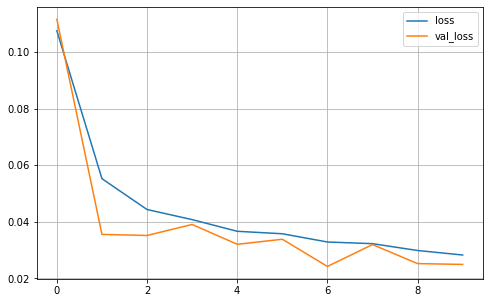

In [6]:
fig, ax = plt.subplots(figsize=(8,5), ncols=1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history['val_loss'], label="val_loss")
ax.grid()
ax.legend()

# ax[1].plot(history.history["accuracy"])
# ax[1].plot(history.history["val_accuracy"])
# ax[1].grid()

## Predicting results
1. Set sigma and xshift, create gaussian function ```ggo``` accordingly
2. Transform ```ggo``` using the created scaler and pass it into the network
3. Gather sigma prediction
4. For comparison, plot original gaussian function and generated function based on prediction

Predicted sigma is: 1.895, which is 0.26% difference from the original.


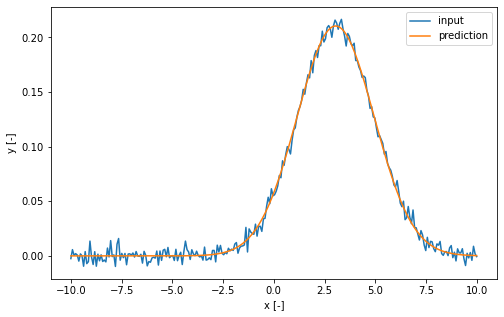

In [9]:
ts = 1.9
xs = np.random.default_rng().uniform(low=-5.0, high=5.0)
ggo = gauss(x, sigma=ts, xshift=xs, noise=ns)

sigma_pred = model.predict(scaler.transform(np.array([ggo])))[0][0]
diff = ((np.abs(sigma_pred-ts))/ts)*100
print("Predicted sigma is: "+str(np.round(sigma_pred,3))+", which is "+str(np.round(diff,2))+"% difference from the original.")

# compare result with prediction
fig, ax = plt.subplots(figsize=(8,5), ncols=1)
ax.plot(x, ggo, label="input")
ax.plot(x, gauss(x, sigma=sigma_pred,  xshift=xs, noise=False), label="prediction")
ax.set(xlabel="x [-]", ylabel="y [-]")
ax.legend()

# fig.savefig("nn_test.png")